In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import configparser as cp
import cv2
import numpy as np
from pickle import dump
from pickle import load
import glob
import time

%matplotlib inline


## Review Train Data

In [2]:
# Function to get training images
def get_train_data():
    images = glob.glob('data/*/*/*.png', recursive=True)
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars

cars, notcars = get_train_data()

# Testing Which Color Space to Use

In [23]:
# Parameters for feature extraction
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [480, None] # Min and max in y to search in slide_window()

cars, notcars = get_train_data()

In [4]:
def svc_model(X_train, y_train, num_folds = 5):
    svc = make_pipeline(preprocessing.StandardScaler(), LinearSVC())
    # Check the training time for the SVC
    scores = cross_val_score(svc, X_train, y_train, cv=num_folds)
    return scores

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys', 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# def color_hist(img, nbins=32, bins_range=(0, 256)):
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    transform_sqrt=True  # we will set this false if color space = LUV or YUV
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Hog function can cause error in YUV or LUV color spaces
            if color_space == 'LUV' or color_space == 'YUV' :
                transform_sqrt=False
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, transform_sqrt=transform_sqrt))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=transform_sqrt)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

In [31]:
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
results=[]
color_space_name = []

for color_space in color_spaces:
    t=time.time()
    print('Extracting features for {}'.format(color_space))
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...\nStarting model training\n')
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    t=time.time()
    svc_scores = svc_model(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    msg = '{}: {:.4f} ({:.4f})\n'.format(color_space, svc_scores.mean(), svc_scores.std())
    print(msg)
    print('=====\n')
    results.append(svc_scores)
    color_space_name.append(color_space)

Extracting features for RGB
97.95 Seconds to extract features...
Starting model training

89.82 Seconds to train SVC...
RGB: 0.9690 (0.0017)

=====

Extracting features for HSV
92.55 Seconds to extract features...
Starting model training

74.23 Seconds to train SVC...
HSV: 0.9820 (0.0026)

=====

Extracting features for LUV
86.06 Seconds to extract features...
Starting model training

67.72 Seconds to train SVC...
LUV: 0.9798 (0.0014)

=====

Extracting features for HLS
89.23 Seconds to extract features...
Starting model training

81.32 Seconds to train SVC...
HLS: 0.9783 (0.0018)

=====

Extracting features for YUV
91.62 Seconds to extract features...
Starting model training

71.85 Seconds to train SVC...
YUV: 0.9830 (0.0014)

=====

Extracting features for YCrCb
93.71 Seconds to extract features...
Starting model training

68.42 Seconds to train SVC...
YCrCb: 0.9846 (0.0029)

=====



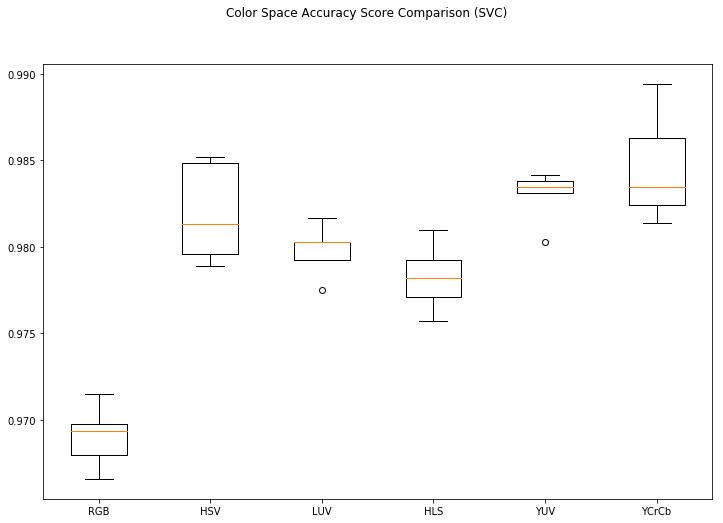

In [32]:
# Compare Color Spaces
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.suptitle('Color Space Accuracy Score Comparison (SVC)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(color_space_name)
plt.show()

## Determine Orientations

In [33]:
# Parameters for feature extraction
color_space = 'YCrCb'
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [480, None] # Min and max in y to search in slide_window()

cars, notcars = get_train_data()

In [34]:
orient_values = [6, 9, 10, 12]
results=[]
orient_value_name = []

for orient in orient_values:
    t=time.time()
    print('Extracting features for orient: {}'.format(orient))
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...\nStarting model training\n')
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    t=time.time()
    svc_scores = svc_model(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    msg = '{}: {:.4f} ({:.4f})\n'.format(orient, svc_scores.mean(), svc_scores.std())
    print(msg)
    print('=====\n')
    results.append(svc_scores)
    orient_value_name.append(orient)

Extracting features for orient: 6
94.34 Seconds to extract features...
Starting model training

42.26 Seconds to train SVC...
YCrCb: 0.9844 (0.0010)

=====

Extracting features for orient: 9
109.03 Seconds to extract features...
Starting model training

70.43 Seconds to train SVC...
YCrCb: 0.9847 (0.0030)

=====

Extracting features for orient: 10
96.65 Seconds to extract features...
Starting model training

74.97 Seconds to train SVC...
YCrCb: 0.9854 (0.0031)

=====

Extracting features for orient: 12
109.94 Seconds to extract features...
Starting model training

94.65 Seconds to train SVC...
YCrCb: 0.9854 (0.0015)

=====



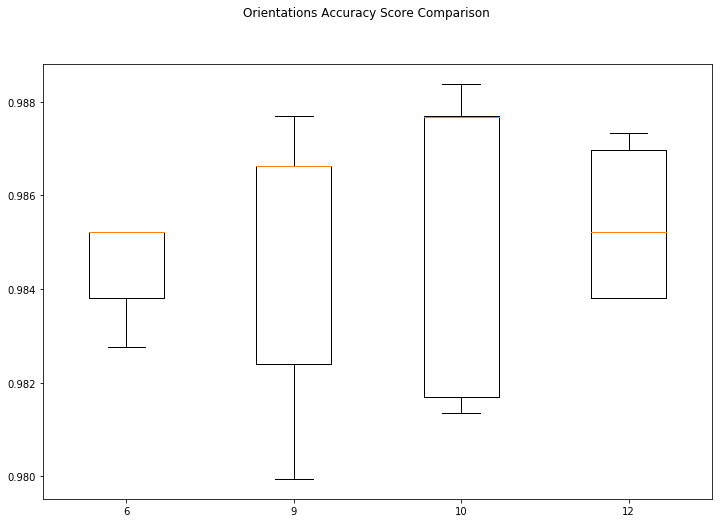

In [35]:
# Compare orientations
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.suptitle('Orientations Accuracy Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(orient_value_name)
plt.show()

## Determine Pixel per Cell

In [36]:
# Parameters for feature extraction
color_space = 'YCrCb'
cell_per_block = 2 # HOG cells per block
orient = 9
hog_channel = 'ALL'
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [480, None] # Min and max in y to search in slide_window()

cars, notcars = get_train_data()

In [37]:
pix_per_cell_values = [6, 8, 12, 16]
results=[]
pix_per_cell_value_name = []

for pix_per_cell in pix_per_cell_values:
    t=time.time()
    print('Extracting features for pix_per_cell: {}'.format(pix_per_cell))
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...\nStarting model training\n')
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    t=time.time()
    svc_scores = svc_model(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    msg = '{}: {:.4f} ({:.4f})\n'.format(pix_per_cell, svc_scores.mean(), svc_scores.std())
    print(msg)
    print('=====\n')
    results.append(svc_scores)
    pix_per_cell_value_name.append(pix_per_cell)


Extracting features for pix_per_cell: 6
132.08 Seconds to extract features...
Starting model training

127.43 Seconds to train SVC...
6: 0.9811 (0.0009)

=====

Extracting features for pix_per_cell: 8
96.37 Seconds to extract features...
Starting model training

66.91 Seconds to train SVC...
8: 0.9839 (0.0025)

=====

Extracting features for pix_per_cell: 12
53.85 Seconds to extract features...
Starting model training

23.28 Seconds to train SVC...
12: 0.9838 (0.0040)

=====

Extracting features for pix_per_cell: 16
47.71 Seconds to extract features...
Starting model training

15.41 Seconds to train SVC...
16: 0.9859 (0.0014)

=====



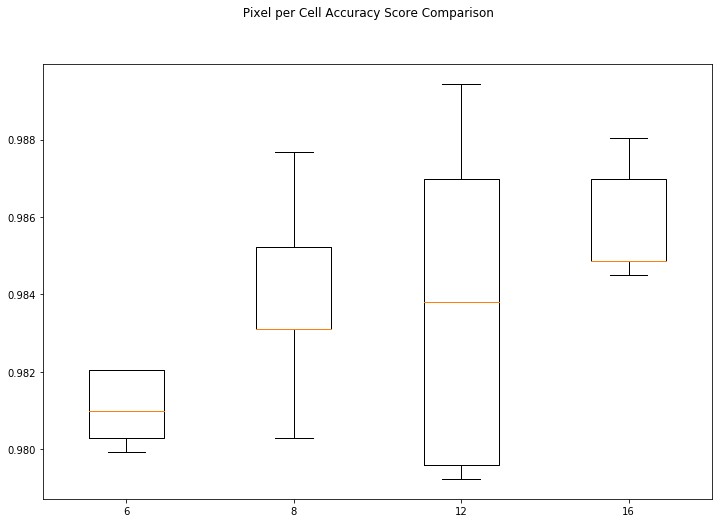

In [38]:
# Compare pix_per_cell
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.suptitle(' Pixel per Cell Accuracy Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(pix_per_cell_value_name)
plt.show()

## Detemine Cells per block

In [7]:
# Parameters for feature extraction
color_space = 'YCrCb'
orient = 9
pix_per_cell = 16
hog_channel = 'ALL'
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [480, None] # Min and max in y to search in slide_window()

cars, notcars = get_train_data()

In [12]:
cell_per_block_value = [2, 4]
results=[]
cell_per_block_value_name = []

for cell_per_block in cell_per_block_value:
    t=time.time()
    print('Extracting features for cell_per_block: {}'.format(cell_per_block))
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...\nStarting model training\n')
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    t=time.time()
    svc_scores = svc_model(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    msg = '{}: {:.4f} ({:.4f})\n'.format(cell_per_block, svc_scores.mean(), svc_scores.std())
    print(msg)
    print('=====\n')
    results.append(svc_scores)
    cell_per_block_value_name.append(cell_per_block)


Extracting features for cell_per_block: 2
75.76 Seconds to extract features...
Starting model training

18.82 Seconds to train SVC...
2: 0.9875 (0.0018)

=====

Extracting features for cell_per_block: 4
78.89 Seconds to extract features...
Starting model training

10.49 Seconds to train SVC...
4: 0.9855 (0.0015)

=====



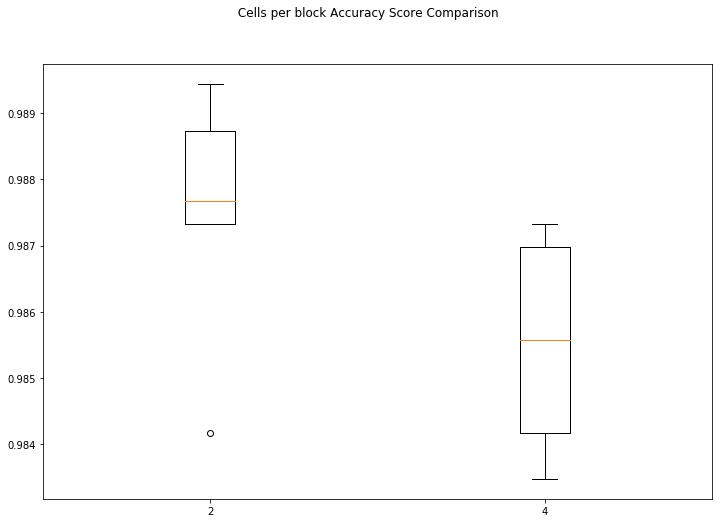

In [13]:
# Compare Cells per block
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.suptitle(' Cells per block Accuracy Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(cell_per_block_value_name)
plt.show()